In [1]:
import sys
sys.path.append("..")
from modules.utils import generate_matrix_close_to_isometry, generate_matrix_far_from_isometry, isometry_gap, ortho_gap
from modules.models import MLPWithBatchNorm, SinAct, CustomNormalization
from torch import nn
import torch
from torch.func import jacfwd
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import matplotlib
import itertools
from constants import *
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets
matplotlib.rcParams["figure.dpi"] = 80
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sns.set(rc={"figure.dpi":80, 'savefig.dpi':80})
sns.set_theme()
sns.set_context('paper')
palette = sns.color_palette("tab10")
style = {"grid.linestyle": ":", 
        "border.color": "black",
       "axes.edgecolor": "black",
       "xtick.bottom": "True",
       "xtick.top": "True",
       "ytick.left": "True",
       "ytick.right": "True",
       "xtick.direction": "in",
       "ytick.direction": "in"}

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

d = 100
n = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'

root_dir = 'FILL_HERE'
train_set = datasets.CIFAR10(root=root_dir, train=True, download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=n, shuffle=True)
test_x, test_y = next(iter(train_loader))
test_x = test_x.to(device).flatten(1, -1)
test_y = test_y.to(device)

In [7]:
inits = ['orthogonal']
exponents = [0.0, -0.4]
act_names = ['identity', 'sin', 'tanh']
depths = [5, 10, 20, 50, 100, 200, 500, 1000]

runs = list(itertools.product(*[inits, act_names, depths, exponents]))

In [9]:
df = []
for run in tqdm(runs):
    init_type, act_name, L, exponent = run
    if init_type == 'identity' and exponent != 0.0:
        continue
    for expi in range(10):
        activation = ACTIVATIONS[act_name]
        model = MLPWithBatchNorm(input_dim=3072, 
                                output_dim=10, 
                                num_layers=L, 
                                hidden_dim=d, 
                                norm_type='torch_bn',
                                mean_reduction=False,
                                activation=activation,
                                exponent=exponent,
                                bias=True,
                                order='norm_act',
                                save_hidden=True).to(device)

        model.reset_parameters(init_type, gain=GAINS[act_name])

        criterion = nn.CrossEntropyLoss()
        model.zero_grad()
        y_pred = model(test_x)
        outputs = model.hiddens
        loss = criterion(y_pred, test_y)
        loss.backward()

        df.append({
            'grad': model.layers[f'fc_1'].weight.grad.norm().log().item(),
            'Activation': act_name,
            'Initialization': init_type,
            'Exponent': exponent,
            'Depth': L
        })
df = pd.DataFrame(df)

100%|██████████| 48/48 [04:42<00:00,  5.88s/it]


C:\Users\PC\AppData\Local\Temp\ipykernel_21512\4119408941.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


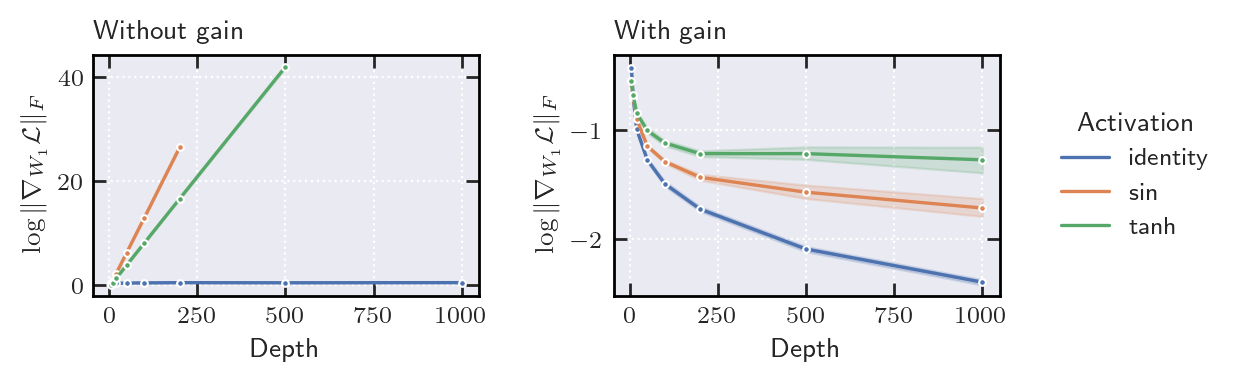

In [10]:
sns.set_style('darkgrid', style)
fig, ax = plt.subplots(dpi=200, ncols=2, figsize=(6.5,2))
sns.lineplot(df[df['Exponent'] == 0.0], x='Depth', y='grad', hue='Activation', marker='.', ax=ax[0], legend=False)
sns.lineplot(df[df['Exponent'] == -0.4], x='Depth', y='grad', hue='Activation', marker='.', ax=ax[1])
ax[0].set_ylabel(r'$\log \| \nabla_{W_1} \mathcal{L} \|_F$')
ax[1].set_ylabel(r'$\log \| \nabla_{W_1} \mathcal{L} \|_F$')
ax[0].set_title(f'Without gain', loc='left')
ax[1].set_title(f'With gain', loc='left')
ax[1].legend(frameon=False, title='Activation')
sns.move_legend(ax[1], "center right", bbox_to_anchor=(1.6, 0.5))
fig.tight_layout()
fig.show()

In [13]:
img_name = "gain.pdf"
fig.savefig('images/'+img_name)